In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
import scipy
from scipy import stats
import os
%matplotlib inline

In [44]:
def read_file(myfile):
    data_array = []
    infile = open(myfile, 'r')
    
    for line in infile:
        temp_list = []
        line = line.strip().split('\t')
        try:
            temp_list.append(line[0].strip()) #append the well
            temp_list.append(int(line[1].strip())) #append the cycle
            temp_list.append(float(line[2].replace(',', ''))) #append the ROX
            temp_list.append(float(line[3].replace(',', ''))) #append SYBR green
            data_array.append(temp_list)
        except:
            continue
    infile.close()
    return data_array

data_array1 = read_file('data1.txt')
nump_array = np.array(data_array1)
df1 = pd.DataFrame(nump_array, columns = ['well', 'time', 'ROX', 'fl'])
print df1.head()

data_array2 = read_file('data2.txt')
nump_array2 = np.array(data_array2)
df2 = pd.DataFrame(nump_array2, columns = ['well', 'time', 'ROX', 'fl'])
print df2.head()


  well time         ROX           fl
0   A4    1  120849.055  1069815.125
1   A5    1  102716.523   662132.688
2   A6    1   96615.406   840290.188
3   A7    1   95078.148   823948.688
4  A10    1   97418.469    671196.25
  well time         ROX          fl
0   A5    1  103450.883    858746.5
1   B5    1   94386.375  748485.688
2   C5    1   80710.586  670561.625
3   D5    1   87284.461  679416.125
4   E5    1   84253.727  705067.312


In [45]:
df1bb = df1[~df1['well'].str.contains('5')]
df1bbb = df1bb[~df1bb['well'].str.contains('4')]
df1bbbb = df1bbb[~df1bbb['well'].str.contains('5')]
df1c = df1bbbb[~df1bbbb['well'].str.contains('10')]
df1cc = df1c[~df1c['well'].str.contains('E2')]
df1ccc = df1cc[~df1cc['well'].str.contains('E3')]
df1d = df1ccc[~df1ccc['well'].str.contains('F2')]
df1dd = df1d[~df1d['well'].str.contains('F3')]
df1e = df1dd[~df1dd['well'].str.contains('G2')]
df1f = df1e[~df1e['well'].str.contains('H3')]
df1b = df1f[~df1f['well'].str.contains('H2')]
df1b.head()

,well,time,ROX,fl
2,A6,1,96615.406,840290.188
3,A7,1,95078.148,823948.688
7,B6,1,86217.258,731566.188
8,B7,1,90681.992,766097.875
12,C6,1,85610.773,710259.688


In [46]:
df3 = pd.concat([df1b, df2]) #merge the two data frames

In [47]:
df3['time'] = df3['time'].apply(lambda x: int(x)*10)
df3['ROX'] = df3['ROX'].apply(lambda x: float(x))
df3['fl'] = df3['fl'].apply(lambda x: float(x))
df3.head()
df3[-5:-1]

,well,time,ROX,fl
485,C5,700,81724.484,1698680.875
486,D5,700,88876.438,1727733.875
487,E5,700,84059.062,1618664.000
488,F5,700,80415.602,1303383.500


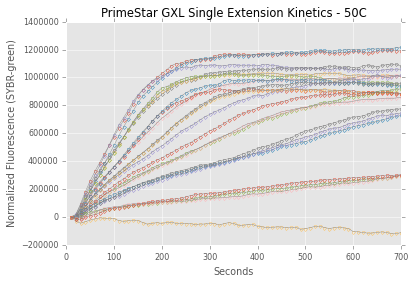

In [67]:
#normalize the fluorescence to ROX. if ROX decreases by 5% of it's value, SYBR green should
# increaseby 5% of it's value and vise versa.
#First group by wells. Then take the ROX Value at 10 seconds as 100%. 
import warnings
warnings.filterwarnings('ignore')
df_gp = df3.groupby('well')
for well, group in df_gp:   
    subset_df_gp = group[group['time']==10]
    rox = subset_df_gp['ROX']
    group['rox_norm'] = group['ROX'].apply(lambda x: x/rox)
    y = group['rox_norm']
    group['fl_norm'] = group['fl'].divide(group['rox_norm'])
#Now subtract the first data point at ten seconds to take the flour values to start at ten sec.
    subset_df_gp2 = group[group['time']==10]
    z = subset_df_gp2['fl_norm']
    group['fl_norm_sub'] = group['fl_norm'].apply(lambda x: x - z)
#Now make the ROX and background corrected plots
    plt.plot(group['time'], group['fl_norm_sub'], '.', mfc='none')
    plt.plot(group['time'], group['fl_norm_sub'], '-', color='grey', linewidth='0.4')
    plt.title('PrimeStar GXL Single Extension Kinetics - 50C')
    plt.xlabel('Seconds')
    plt.ylabel('Normalized Fluorescence (SYBR-green)')
    plt.savefig('2015-12-21_PS_GXL_Pol_kinetic_assay', bbox_inches='tight')    
plt.show()
                          

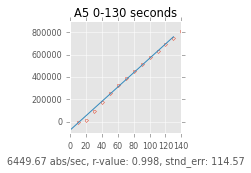

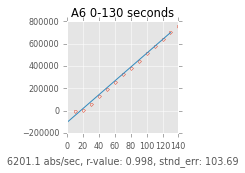

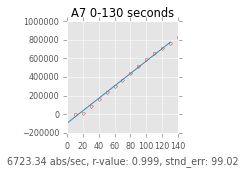

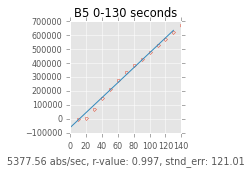

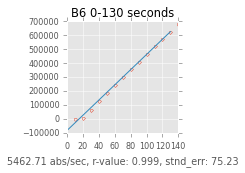

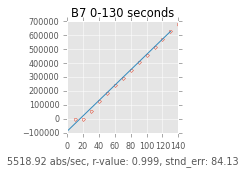

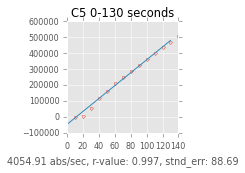

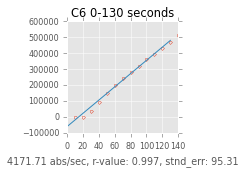

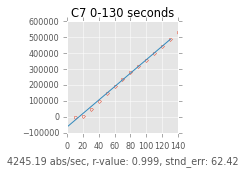

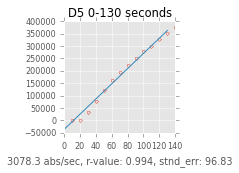

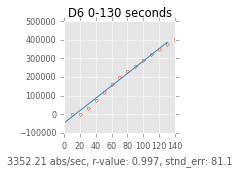

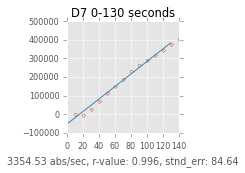

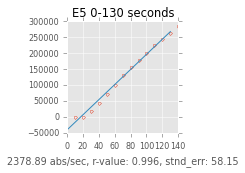

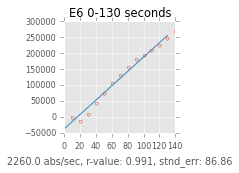

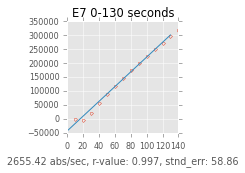

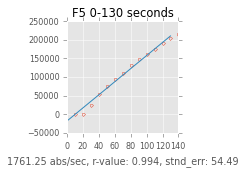

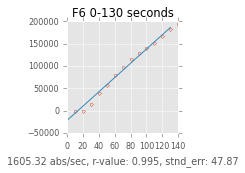

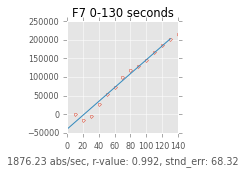

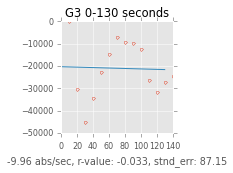

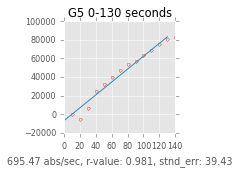

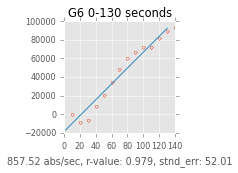

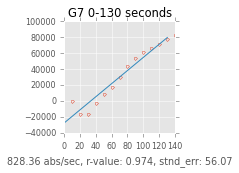

In [54]:
#Now make the initial rate plots
wells_list = []
activity_list = []
z2 = []
for well, group in df_gp:
    wells_list.append(well)
    subset_df_gp = group[group['time']==10]
    rox = subset_df_gp['ROX']
    group['rox_norm'] = group['ROX'].apply(lambda x: x/rox)
    y = group['rox_norm']
    group['fl_norm'] = group['fl'].divide(group['rox_norm'])
#Now subtract the first data point at ten seconds to take the flour values to start at ten sec.
    subset_df_gp2 = group[group['time']==10]
    z = subset_df_gp2['fl_norm']
    group['fl_norm_sub'] = group['fl_norm'].apply(lambda x: x - z)
    z2.append(group['fl_norm_sub'])
#Make the regression lines for each plot.
    regressionline = stats.linregress(group['time'][0:14], group['fl_norm_sub'][0:14])
    m = regressionline[0]
    b = regressionline[1]
    r_value = regressionline[2]
    stnd_error = regressionline[4]
    x = np.linspace(0, 130)
    activity_list.append(m)
#Make the plots 
    matplotlib.style.use("ggplot")    
    plt.figure(figsize=(2,2))
    plt.rcParams.update({'font.size': 8})
    plt.xlabel('%s abs/sec, r-value: %s, stnd_err: %s' %(round(m,2), round(r_value,3), round(stnd_error,2)))
    plt.plot(group['time'][0:14], group['fl_norm_sub'][0:14], '.', mfc='none')
    plt.plot(x, m*x + b, '-')
    plt.title(well+' 0-130 seconds')
    plt.savefig('2015-21-15_1-PSGXL-50c'+well, bbox_inches='tight')
    plt.show()

In [55]:
#create boxplot with standard deviations
print activity_list
print wells_list
print len(activity_list)
print len(wells_list)

[6449.6743924358279, 6201.1046909679526, 6723.341854361558, 5377.5588147520757, 5462.7137995586118, 5518.9216072725903, 4054.9107794495699, 4171.713400864739, 4245.1879029028269, 3078.3043610453965, 3352.2066575566205, 3354.531244088279, 2378.8931495377724, 2260.0002206011336, 2655.4206657815589, 1761.2492590547004, 1605.3215724930903, 1876.2301060440275, -9.9642880955261734, 695.47124397285143, 857.52385632763583, 828.35779569910562]
['A5', 'A6', 'A7', 'B5', 'B6', 'B7', 'C5', 'C6', 'C7', 'D5', 'D6', 'D7', 'E5', 'E6', 'E7', 'F5', 'F6', 'F7', 'G3', 'G5', 'G6', 'G7']
22
22


In [58]:
#new_wells_2 = ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2']
a = np.array(activity_list[0:3])
b = np.array(activity_list[3:6])
c = np.array(activity_list[6:9])
d = np.array(activity_list[9:12])
e = np.array(activity_list[12:15])
f = np.array(activity_list[15:18])
g = np.array(activity_list[19:22])
#h = np.array(activity_list[18:19])
print a,b,c,d,e,f,g

[ 6449.67439244  6201.10469097  6723.34185436] [ 5377.55881475  5462.71379956  5518.92160727] [ 4054.91077945  4171.71340086  4245.1879029 ] [ 3078.30436105  3352.20665756  3354.53124409] [ 2378.89314954  2260.0002206   2655.42066578] [ 1761.24925905  1605.32157249  1876.23010604] [ 695.47124397  857.52385633  828.3577957 ]


In [59]:
data_to_plot = [a, b, c, d, e, f, g]
#print data_to_plot
mean = [np.mean(x) for x in data_to_plot]
std = [np.std(x) for x in data_to_plot]

mean_round = [round(x,2) for x in mean]
std_round = [round(x, 3) for x in std]

print 'means:', mean_round
print 'standard deviations:', std_round

means: [6458.04, 5453.06, 4157.27, 3261.68, 2431.44, 1747.6, 793.78]
standard deviations: [213.284, 58.113, 78.349, 129.67, 165.65, 111.018, 70.53]


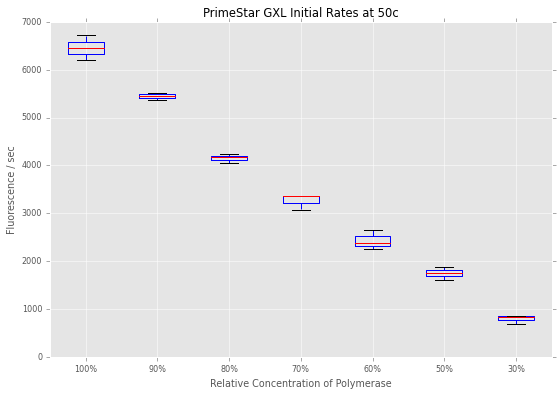

In [66]:
# Create a figure instance
x_list = ['100%', '90%', '80%', '70%', '60%', '50%', '30%']
fig = plt.figure(1, figsize=(9, 6))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(data_to_plot)
plt.title('PrimeStar GXL Initial Rates at 50c')
plt.ylabel('Fluorescence / sec')
plt.xlabel('Relative Concentration of Polymerase')
plt.xticks([1, 2, 3, 4, 5, 6, 7], x_list)
# Save the figure
fig.savefig('12-21-15-PrimeStarGXL-50c_activity.png', bbox_inches='tight')